In [2]:
### power_spectra_game --- i.e., can you detect the power at a specific frequency over the red noise null hypothesis?
### in class activity lecture #10 - ATOC7500 Objective Data Analysis
### original Libby Barnes (CSU), additional coding/commenting/conversion to ipynb3 and game by Jennifer Kay (CU)
### last updated October 14, 2020
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy.signal as sig
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
## needed in ipython notebooks to make plots appear in-line

frequency of oscillation (per timestep): 0.1953125


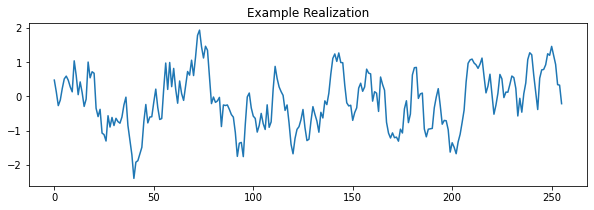

In [55]:
### input parameters for creation of synthetic data set: red noise with oscillation
def test_peaks(T, alpha, xcosamp, xcosfreq):
    # T = 256                #length of window (default 256 timesteps)
    # alpha = 0.9            #red noise lag-one autocorrelation (default 0.5, try increasing to 0.9 or decreasing to 0.1)
    # xcosamp = 0.1          #amplitude of oscillation (default 0.5, try increasing to 5 or decreasing to 0.1)
    # xcosfreq = (50/256.)  #frequency of oscillation (default 50./256., try 10./256. or 100./256.)
    # print('frequency of oscillation (per timestep):',xcosfreq)

    # Example realization - red noise with oscillation
    fig=plt.figure(figsize=(10,2))
    factor = np.sqrt(1.-alpha*alpha)
    x = np.zeros(T,)
    x[0] = x[-1]*alpha + factor*np.random.randn() 
    for j in np.arange(1,T,1):
        x[j] = x[j-1]*alpha + factor*np.random.randn()+xcosamp*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*xcosfreq*j)
    plt.plot(x);
    plt.title('Example Realization');

    ### spectral analysis parameters
    T2 = T/2                      #number of spectral estimates
    freq = np.arange(0.,T2+1.)/T  #frequency of spectral estimates

    ### construct the expected rednoise spectrum (this is your null hypothesis)
    rspec = []
    for i in np.arange(1,T2+2,1):
        rspec.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/T2)+alpha*alpha))


    ## Now you are ready to play!!

    ## Look at N number of realizations of randomly generated data with weak spectral power
    ## See if any statistically significant peaks are detected
    ## Does this remind you of application lab #2?
    ## Instead of "fishing for correlation" we are now are fishing for statistically significant peaks" 
    ## and also seeing the influence of increasing the number of realizations we are using on this fishing expedition.

    ## note: the more realizations (larger N) the easier it is to detect the peak
    ## note: the redder the timeseries (larger alpha) the easier it is to detect the peak
    ## note: the larger the amplitude of the peak (larger xcosamp) the easier it is to detect the peak

    # loop through N realizations - plot results
    N = 40    #number of realizations (default 40)

    ## plotting set-up
    nplots=round(N/5)+1
    gs=GridSpec(nplots,1)
    foo=0
    fig=plt.figure(figsize=(10,20))

    for ir in np.arange(0,N,1): 
        ## generate random timeseries with weak spectral power
        x[0] = x[-1]*alpha + factor*np.random.randn() 
        for j in np.arange(1,T,1):
            x[j] = x[j-1]*alpha + factor*np.random.randn()+xcosamp*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*xcosfreq*j)
        ## calculate the power spectra using Welch's method
        ## see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html    
        p = sig.welch(x,window='hanning',nperseg=T);
        if(ir==0):
            psum = p[1]
        else:
            psum = psum + p[1]
        # calculate average    
        pave = psum/(ir+1.0)
        #normalize the spectrum
        pave = pave/np.mean(pave)
        #calculate significance
        dof = 2.*(ir+1.)
        fstat = stats.f.ppf(.99,dof,1000)
        spec99 = [fstat*m for m in rspec]
        if((ir+1.) % 5 == 0 or ir==0):       ## "(ir+1.) % 5" means is (ir+1.) divisible by 5 
            plt.subplot(gs[foo,0])
            plt.xlabel('frequency (cycles per time step)')
            plt.ylabel('power')
            plt.title('# Realizations ' + str(ir+1))
            if(ir<15):
                plt.ylim(0,15.)
            else:
                plt.ylim(0,5.)            
            plt.plot(freq,pave,'-k', label = 'data');
            plt.plot(freq,rspec,'-', label = 'red-noise fit', color = 'blue');
            plt.plot(freq,spec99,'--', label = '99% confidence', color = 'red');
            plt.legend(frameon = False);
            foo=foo+1
            #print(foo)
            fig.tight_layout()
        plt.ylim(0.001,100)
        plt.yscale('log')
        plt.title('T: {},  Alpha: {},  Cos amp: {},  Cos freq: {}'.format(str(T),str(alpha),str(xcosamp),str(round(xcosfreq,4)))) 

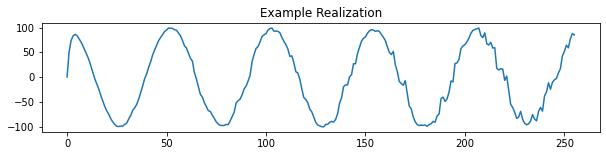

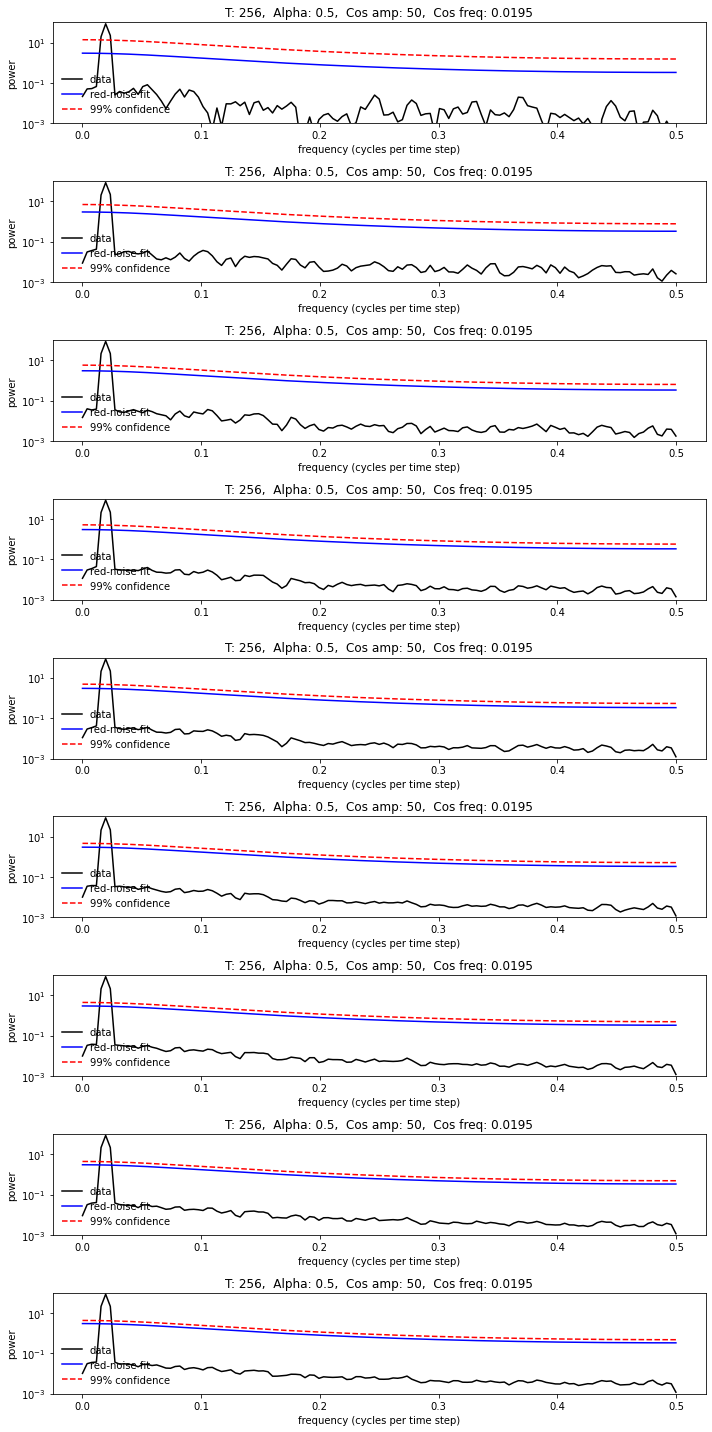

In [66]:
#default, T = 256 length of window, alpha = 0.5 red noise (AR1), xcosamp = 0.5 amplitude of oscillation,  xcosfreq = (50/256.) 
test_peaks(256, 0.5, 50, 5/256)
#increasing T makes more smaller peaks, more chances of there being different contributing frequencies
#increasing alpha increases the peak at the low frequencies (but also the 99% CI line) why the 99% CI line too?????
#increasing xcosamp makes the peak more noticable
#increasing the xcosfreq moves the peak more towards the right (higher frequencies)

In [4]:
def CI_red_fit(T, alpha, CI, N): #length of window, AR1 for red noise, CI e.g. 0.99, number of realizations
    freq = np.arange(0.,(T/2)+1)/T  #frequency of spectral estimates

    rspec = [] #construct expected rednoise spectrum (H0)
    for i in np.arange(1,(T/2)+2,1):
        rspec.append((1.-alpha*alpha)/(1-2*alpha*np.cos(np.pi*(i-1)/(T/2))+alpha*alpha))

    fstat = stats.f.ppf(CI,2,1000) 
    spec99 = [fstat*m for m in rspec]
    
    return(freq, rspec, spec99)

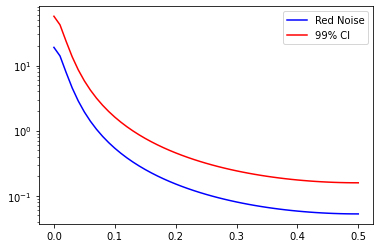

In [14]:
a = CI_red_fit(100,0.9,0.95, 1)

plt.plot(a[0], a[1], c='b', label='Red Noise')
plt.plot(a[0], a[2], c='r', label='99% CI')
plt.yscale('log')
plt.legend()